In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, label_binarize, OrdinalEncoder
from category_encoders import CatBoostEncoder, MEstimateEncoder

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.linear_model import RidgeClassifier, LogisticRegression, LinearRegression, BayesianRidge, Ridge

from sklearn import set_config
import os

import optuna
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve, make_scorer, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, matthews_corrcoef
from scipy.stats import norm, skew

from colorama import Fore, Style, init
from copy import deepcopy
from sklearn.base import BaseEstimator, TransformerMixin
from pprint import pprint
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, KFold, RepeatedKFold, cross_val_score, StratifiedGroupKFold
from xgboost import DMatrix, XGBClassifier, XGBRegressor
from lightgbm import log_evaluation, early_stopping, LGBMClassifier, LGBMRegressor, Dataset
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from tqdm.notebook import tqdm
from optuna.samplers import TPESampler, CmaEsSampler
from optuna.pruners import HyperbandPruner
from functools import partial
from IPython.display import display_html, clear_output
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
# from cuml.preprocessing import TargetEncoder
import gc
import re

import keras
from keras.models import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

**Dataset Description**:
* **id**: A unique identifier for each record.
* **Brand**: The brand name of the bag (e.g., Jansport, Under Armour, Nike).
* **Material**: The material of the bag (e.g., Leather, Canvas, Nylon).
* **Size**: The size category of the bag (e.g., Medium, Small).
* **Compartments**: The number of compartments in the bag.
* **Laptop Compartment**: Indicates if the bag has a laptop compartment (Yes/No).
* **Waterproof**: Specifies if the bag is waterproof (Yes/No).
* **Style**: The style of the bag (e.g., Tote, Messenger).
* **Color**: The color of the bag (e.g., Black, Green, Red).
* **Weight Capacity (kg)**: The maximum weight the bag can carry.
* **Price**: The price of the bag.

# <p style="border-radius: 40px; color: white; font-weight: bold; font-size: 150%; text-align: center; background-color:#3cb371; padding: 5px 5px 5px 5px;">Configuration</p>

In [2]:
class Config:
    
    state = 42
    n_splits = 5
    early_stop = 200
        
    target = 'Price'
    train = pd.read_csv('/kaggle/input/playground-series-s5e2/train.csv', index_col='id')
    test = pd.read_csv('/kaggle/input/playground-series-s5e2/test.csv', index_col='id')
    submission = pd.read_csv('/kaggle/input/playground-series-s5e2/sample_submission.csv')
    train_org = pd.read_csv('/kaggle/input/playground-series-s5e2/training_extra.csv', index_col='id')
    
    original_data = 'Y'
    outliers = 'N'
    log_trf = 'N'
    scaler_trf = 'N'
    feature_eng = 'Y'
    missing = 'N'

# <p style="border-radius: 40px; color: white; font-weight: bold; font-size: 150%; text-align: center; background-color:#3cb371; padding: 5px 5px 5px 5px;">EDA</p>

In [3]:
class EDA(Config):
    
    def __init__(self):
        super().__init__()

        self.cat_features = self.train.drop(self.target, axis=1).select_dtypes(include=['object']).columns.tolist()
        self.num_features = self.train.drop(self.target, axis=1).select_dtypes(exclude=['object']).columns.tolist()
        self.data_info()
        self.heatmap()
        self.dist_plots()
        self.cat_feature_plots()
        self.target_plot()
                
    def data_info(self):
        
        for data, label in zip([self.train, self.test], ['Train', 'Test']):
            table_style = [{'selector': 'th:not(.index_name)',
                            'props': [('background-color', '#3cb371'),
                                      ('color', '#FFFFFF'),
                                      ('font-weight', 'bold'),
                                      ('border', '1px solid #DCDCDC'),
                                      ('text-align', 'center')]
                            }, 
                            {'selector': 'tbody td',
                             'props': [('border', '1px solid #DCDCDC'),
                                       ('font-weight', 'normal')]
                            }]
            print(Style.BRIGHT+Fore.GREEN+f'\n{label} head\n')
            display(data.head().style.set_table_styles(table_style))
                           
            print(Style.BRIGHT+Fore.GREEN+f'\n{label} info\n'+Style.RESET_ALL)               
            display(data.info())
                           
            print(Style.BRIGHT+Fore.GREEN+f'\n{label} describe\n')
            display(data.describe().drop(index='count', columns=self.target, errors = 'ignore').T
                    .style.set_table_styles(table_style).format('{:.3f}'))
            
            print(Style.BRIGHT+Fore.GREEN+f'\n{label} missing values\n'+Style.RESET_ALL)               
            display(data.isna().sum())
        return self
    
    def heatmap(self):
        print(Style.BRIGHT+Fore.GREEN+f'\nCorrelation Heatmap\n')
        plt.figure(figsize=(7,7))
        corr = self.train.select_dtypes(exclude='object').corr(method='pearson')
        sns.heatmap(corr, fmt = '0.4f', cmap = 'Greens', annot=True, cbar=False)
        plt.show()
        
    def dist_plots(self):
        print(Style.BRIGHT+Fore.GREEN+f"\nDistribution analysis\n")
        df = pd.concat([self.train[self.num_features].assign(Source = 'Train'), 
                        self.test[self.num_features].assign(Source = 'Test'),], 
                        axis=0, ignore_index = True)

        fig, axes = plt.subplots(len(self.num_features), 2 ,figsize = (18, len(self.num_features) * 6), 
                                 gridspec_kw = {'hspace': 0.3, 
                                                'wspace': 0.2, 
                                                'width_ratios': [0.70, 0.30]
                                               }
                                )
        for i,col in enumerate(self.num_features):
            ax = axes[i,0]
            sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', 
                        palette = ['#3cb371', 'r'], ax = ax, linewidth = 2
                       )
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col}")
            ax.grid()

            ax = axes[i,1]
            sns.boxplot(data = df, y = col, x=df.Source, width = 0.5,
                        linewidth = 1, fliersize= 1,
                        ax = ax, palette=['#3cb371', 'r']
                       )
            ax.set_title(f"\n{col}")
            ax.set(xlabel = '', ylabel = '')
            ax.tick_params(axis='both', which='major')
            ax.set_xticklabels(['Train', 'Test'])

        plt.tight_layout()
        plt.show()
               
    def cat_feature_plots(self):
        fig, axes = plt.subplots(len(self.cat_features), 2 ,figsize = (18, len(self.cat_features) * 6), 
                                 gridspec_kw = {'hspace': 0.5, 
                                                'wspace': 0.2,
                                               }
                                )

        for i, col in enumerate(self.cat_features):
            
            ax = axes[i,0]
            sns.barplot(data=self.train[col].value_counts().nlargest(10).reset_index(), x=col, y='count', ax=ax, color='#3cb371')
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col} Train")
            
            ax = axes[i,1]
            sns.barplot(data=self.train[col].value_counts().nlargest(10).reset_index(), x=col, y='count', ax=ax, color='r')
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col} Test")

        plt.tight_layout()
        plt.show()
        
    def target_plot(self):
        print(Style.BRIGHT+Fore.GREEN+f"\nTarget feature distribution\n")
        
        fig, axes = plt.subplots(1, 2 ,figsize = (14, 6), 
                                 gridspec_kw = {'hspace': 0.3, 
                                                'wspace': 0.2, 
                                                'width_ratios': [0.70, 0.30]
                                               }
                                )
        ax = axes[0]
        sns.kdeplot(data = self.train[self.target], 
                    color = '#3cb371', ax = ax, linewidth = 2
                   )
        ax.set(xlabel = '', ylabel = '')
        ax.set_title(f"\n{self.target}")
        ax.grid()

        ax = axes[1]
        sns.boxplot(data = self.train, y = self.target, width = 0.5,
                    linewidth = 1, fliersize= 1,
                    ax = ax, color = '#3cb371'
                   )
        ax.set_title(f"\n{self.target}")
        ax.set(xlabel = '', ylabel = '')
        ax.tick_params(axis='both', which='major')

        plt.tight_layout()
        plt.show()         


Train head



,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
0,Jansport,Leather,Medium,7.000000,Yes,No,Tote,Black,11.611723,112.158750
1,Jansport,Canvas,Small,10.000000,Yes,Yes,Messenger,Green,27.078537,68.880560
2,Under Armour,Leather,Small,2.000000,Yes,No,Messenger,Red,16.643760,39.173200
3,Nike,Nylon,Small,8.000000,Yes,No,Messenger,Green,12.937220,80.607930
4,Adidas,Canvas,Medium,1.000000,Yes,Yes,Messenger,Green,17.749338,86.023120



Train info

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 290295 non-null  object 
 1   Material              291653 non-null  object 
 2   Size                  293405 non-null  object 
 3   Compartments          300000 non-null  float64
 4   Laptop Compartment    292556 non-null  object 
 5   Waterproof            292950 non-null  object 
 6   Style                 292030 non-null  object 
 7   Color                 290050 non-null  object 
 8   Weight Capacity (kg)  299862 non-null  float64
 9   Price                 300000 non-null  float64
dtypes: float64(3), object(7)
memory usage: 25.2+ MB


None


Train describe



,mean,std,min,25%,50%,75%,max
Compartments,5.444,2.891,1.000,3.000,5.000,8.000,10.000
Weight Capacity (kg),18.030,6.967,5.000,12.098,18.069,24.002,30.000



Train missing values



Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)     138
Price                      0
dtype: int64


Test head



,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
id,,,,,,,,,
300000,Puma,Leather,Small,2.000000,No,No,Tote,Green,20.671147
300001,Nike,Canvas,Medium,7.000000,No,Yes,Backpack,Green,13.564105
300002,Adidas,Canvas,Large,9.000000,No,Yes,Messenger,Blue,11.809799
300003,Adidas,Nylon,Large,1.000000,Yes,No,Messenger,Green,18.477036
300004,nan,Nylon,Large,2.000000,Yes,Yes,Tote,Black,9.907953



Test info

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 300000 to 499999
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 193773 non-null  object 
 1   Material              194387 non-null  object 
 2   Size                  195619 non-null  object 
 3   Compartments          200000 non-null  float64
 4   Laptop Compartment    195038 non-null  object 
 5   Waterproof            195189 non-null  object 
 6   Style                 194847 non-null  object 
 7   Color                 193215 non-null  object 
 8   Weight Capacity (kg)  199923 non-null  float64
dtypes: float64(2), object(7)
memory usage: 15.3+ MB


None


Test describe



,mean,std,min,25%,50%,75%,max
Compartments,5.443,2.889,1.000,3.000,5.000,8.000,10.000
Weight Capacity (kg),17.993,6.972,5.000,12.069,18.055,23.966,30.000



Test missing values



Brand                   6227
Material                5613
Size                    4381
Compartments               0
Laptop Compartment      4962
Waterproof              4811
Style                   5153
Color                   6785
Weight Capacity (kg)      77
dtype: int64


Correlation Heatmap



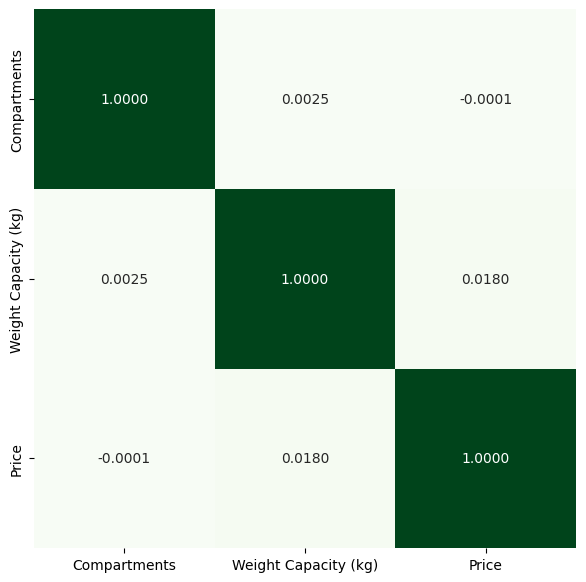


Distribution analysis



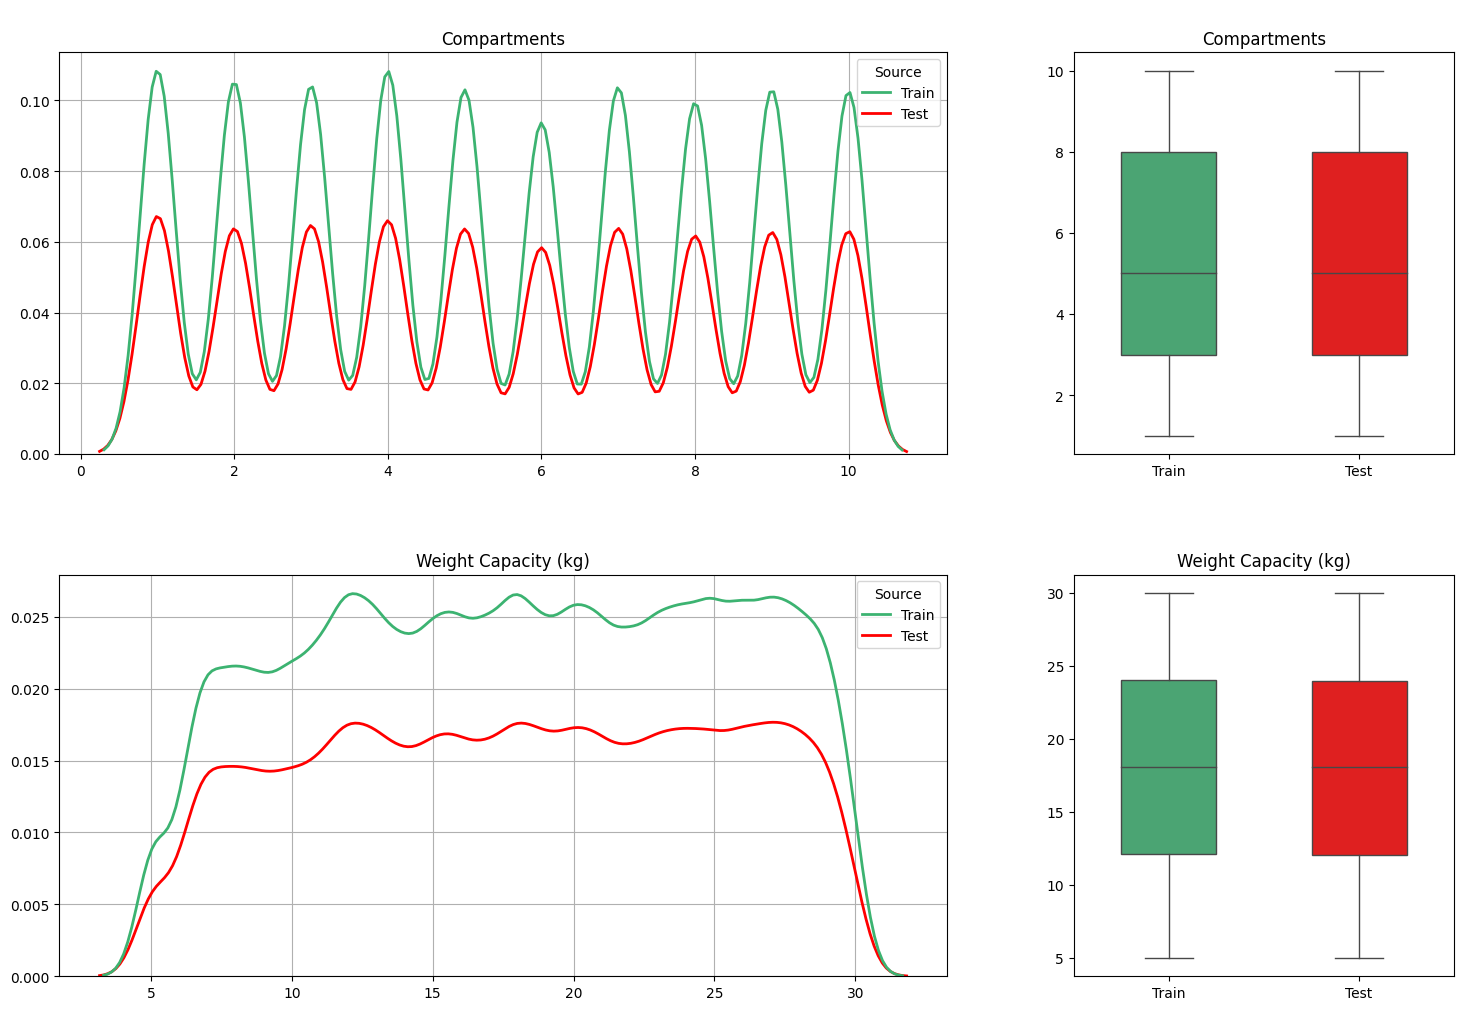

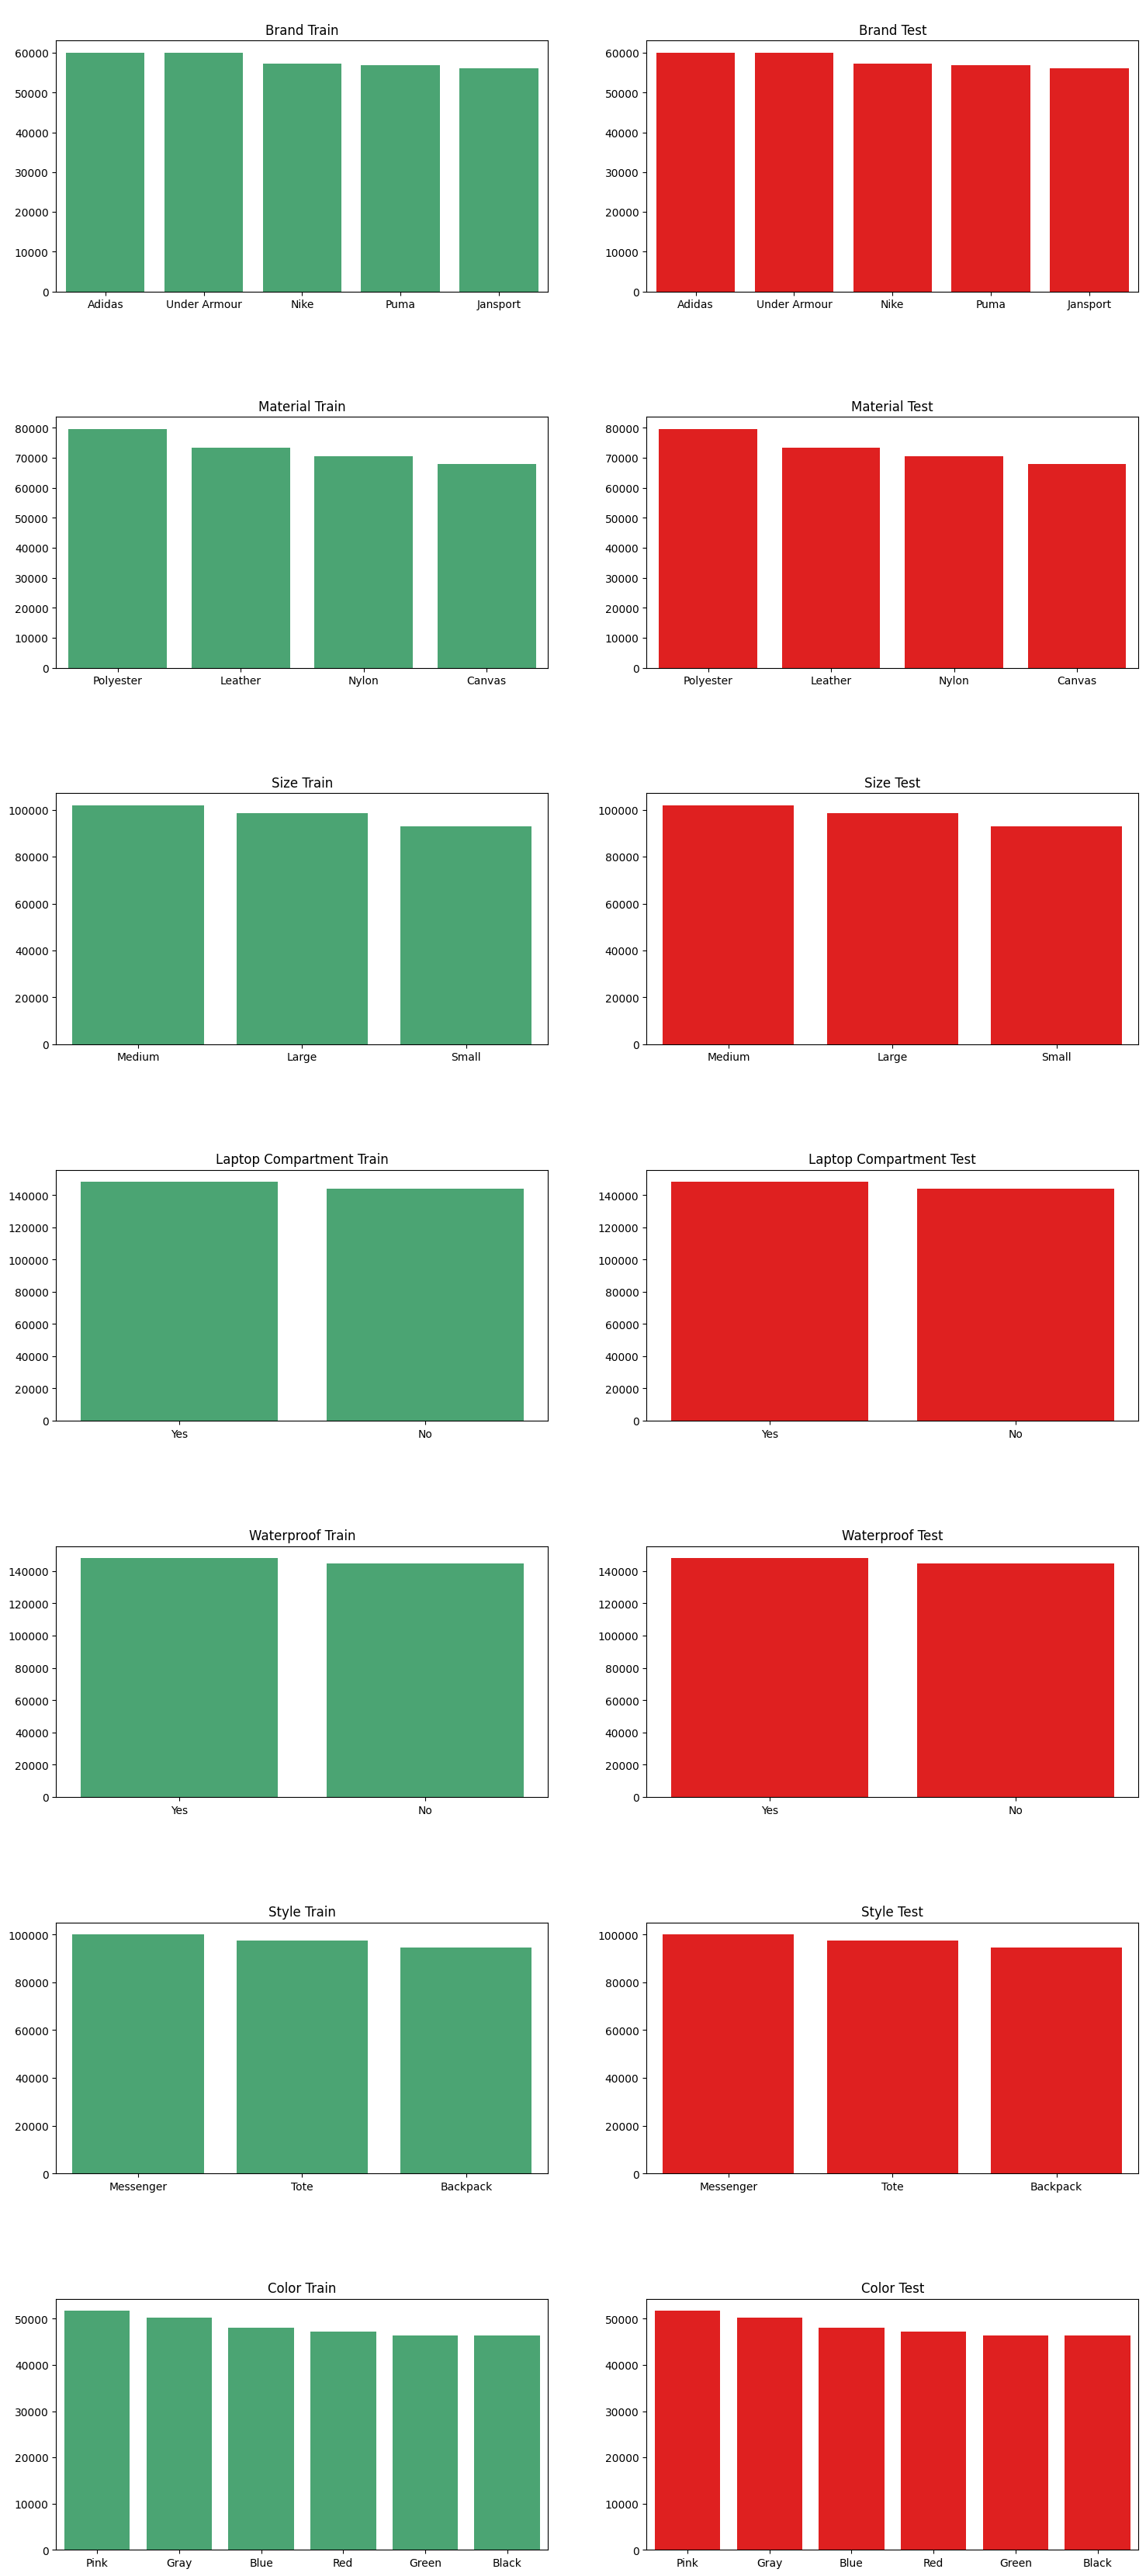


Target feature distribution



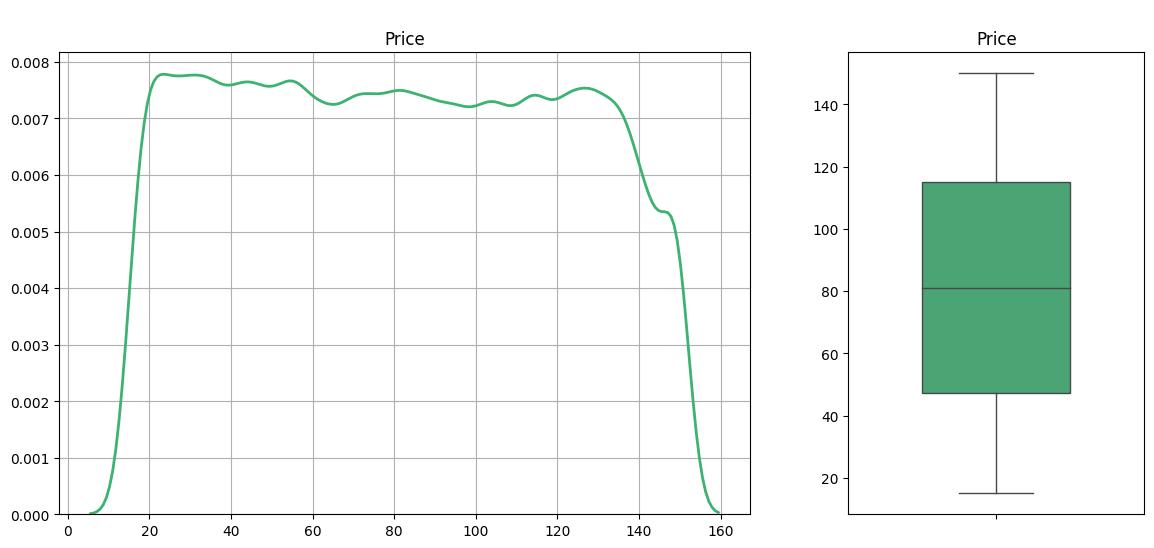

In [4]:
eda = EDA()

# <p style="border-radius: 40px; color: white; font-weight: bold; font-size: 150%; text-align: center; background-color:#3cb371; padding: 5px 5px 5px 5px;">Data Transformation</p>

In [5]:
class Transform(Config):
    
    def __init__(self):
        super().__init__()
        if Config.original_data == 'Y':
            self.train = pd.concat([self.train, self.train_org], ignore_index=True).drop_duplicates()
            self.train.reset_index(drop=True, inplace=True)

        self.num_features = self.train.drop(self.target, axis=1).select_dtypes(exclude=['object', 'bool']).columns.tolist()
        self.cat_features = self.train.drop(self.target, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()
        
        if self.missing == 'Y':
            self.missing_values()
            
        self.train_raw = self.train.copy()
        
        if self.feature_eng == 'Y':
            self.train = self.new_features(self.train)
            self.test = self.new_features(self.test)
            self.train_raw = self.new_features(self.train_raw)
            
        self.num_features = self.train.drop(self.target, axis=1).select_dtypes(exclude=['object', 'bool']).columns.tolist()
        self.cat_features = self.train.drop(self.target, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()
            
        if self.outliers == 'Y':    
            self.remove_outliers()
            
        if self.log_trf == 'Y':
            self.log_transformation()
            
        if self.scaler_trf == 'Y':
            self.scaler()
            
        self.train_enc = self.train.copy()
        self.test_enc = self.test.copy()
        self.encode()
        
        if self.outliers == 'Y' or self.log_trf == 'Y' or self.scaler_trf =='Y':
            self.distribution()
        
    def __call__(self):
        self.num_features = self.train.drop(self.target, axis=1).select_dtypes(exclude=['object', 'bool']).columns.tolist()
        self.cat_features = self.train.drop(self.target, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()

        self.cat_features_card = []
        for f in self.cat_features:
            self.cat_features_card.append(self.train[f].nunique())
        
        self.y = self.train[self.target]
        self.train = self.train.drop(self.target, axis=1)
        self.train_enc = self.train_enc.drop(self.target, axis=1)
        
        return self.train, self.train_enc, self.y, self.test, self.test_enc, self.cat_features
    
    def encode(self):
        data = pd.concat([self.test, self.train])
        oe = OrdinalEncoder()
        data[self.cat_features] = oe.fit_transform(data[self.cat_features]).astype('int')
        
        scaler = StandardScaler()
        data[self.num_features + [self.target]] = scaler.fit_transform(data[self.num_features + [self.target]])
        
        self.train_enc = data[~data[self.target].isna()]
        self.test_enc = data[data[self.target].isna()].drop(self.target, axis=1)
            
    def new_features(self, data):
        data['Compartments'] = data['Compartments'].astype('string').astype('object')
        return data

    def log_transformation(self):
        self.train[self.target] = np.log1p(self.train[self.target]) 
        
        return self
    
    def distribution(self):
        print(Style.BRIGHT+Fore.GREEN+f'\nHistograms of distribution\n')
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

        ax_r, ax_n = axes

        ax_r.set_title(f'{self.target} ($\mu=$ {self.train_raw[self.target].mean():.2f} and $\sigma=$ {self.train_raw[self.target].std():.2f} )')
        ax_r.hist(self.train_raw[self.target], bins=30, color='#3cb371')
        ax_r.axvline(self.train_raw[self.target].mean(), color='r', label='Mean')
        ax_r.axvline(self.train_raw[self.target].median(), color='y', linestyle='--', label='Median')
        ax_r.legend()

        ax_n.set_title(f'{self.target} Normalized ($\mu=$ {self.train_enc[self.target].mean():.2f} and $\sigma=$ {self.train_enc[self.target].std():.2f} )')
        ax_n.hist(self.train_enc[self.target], bins=30, color='#3cb371')
        ax_n.axvline(self.train_enc[self.target].mean(), color='r', label='Mean')
        ax_n.axvline(self.train_enc[self.target].median(), color='y', linestyle='--', label='Median')
        ax_n.legend()
        
    def remove_outliers(self):
        Q1 = self.train[self.targets].quantile(0.25)
        Q3 = self.train[self.targets].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5*IQR
        upper_limit = Q3 + 1.5*IQR
        self.train = self.train[(self.train[self.targets] >= lower_limit) & (self.train[self.targets] <= upper_limit)]
        self.train.reset_index(drop=True, inplace=True) 
        
    def scaler(self):
        scaler = StandardScaler()
        self.train[self.num_features] = scaler.fit_transform(self.train[self.num_features])
        self.test[self.num_features] = scaler.transform(self.test[self.num_features])
        return self
    
    def missing_values(self):

        self.train[self.cat_features] = self.train[self.cat_features].fillna('None')
        self.test[self.cat_features] = self.test[self.cat_features].fillna('None')
        return self

    def reduce_mem(self, df):

        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', "uint16", "uint32", "uint64"]
        
        for col in df.columns:
            col_type = df[col].dtypes
            
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if "int" in str(col_type):
                    if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min >= np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min >= np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min >= np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    if c_min >= np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)  

        return df

In [6]:
t = Transform()
X, X_enc, y, test, test_enc, cat_features = t()

# <p style="border-radius: 40px; color: white; font-weight: bold; font-size: 150%; text-align: center; background-color:#3cb371; padding: 5px 5px 5px 5px;">Model Training</p>

**Neural Network model**

In [7]:
def build_model():
    
    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(t.cat_features_card[j], int(np.ceil(np.sqrt(t.cat_features_card[j]))))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)
        
    x_input_nums = layers.Input(shape=(len(t.num_features),))
    
    x = layers.Concatenate(axis=-1)(embs+[x_input_nums]) 
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1)(x)
    
    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x)
    return model

**YDF model**

In [8]:
from sklearn.base import BaseEstimator, RegressorMixin
import contextlib, io
import ydf; ydf.verbose(2)
from ydf import GradientBoostedTreesLearner

def YDFRegressor(learner_class):

    class YDFXRegressor(BaseEstimator, RegressorMixin):

        def __init__(self, params={}):
            self.params = params

        def fit(self, X, y):
            assert isinstance(X, pd.DataFrame)
            assert isinstance(y, pd.Series)
            target = y.name
            params = self.params.copy()
            params['label'] = target
            params['task'] = ydf.Task.REGRESSION
            X = pd.concat([X, y], axis=1)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                self.model = learner_class(**params).train(X)
            return self

        def predict(self, X):
            assert isinstance(X, pd.DataFrame)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                return self.model.predict(X)

    return YDFXRegressor

In [9]:
models = {
    'NN': [_,
           False],
    'YDF': [YDFRegressor(GradientBoostedTreesLearner)({'num_trees': 1000,
                                                       'max_depth': 6,
                                                       }),
            False],
    'CAT': [CatBoostRegressor(**{'verbose': 0,
                                 'random_state': Config.state,
                                 'cat_features': cat_features,
                                 'early_stopping_rounds': Config.early_stop,
                                 'eval_metric': "RMSE",
                                 'n_estimators' : 3000,
                                 'objective': 'RMSE', 
                                 'depth': 4,
                                 'min_data_in_leaf': 20,
                                 'l2_leaf_reg': 0.3349374242775052,
                                 'bagging_temperature': 0.8315027960954179, 
                                 'random_strength': 0.309798135191685,
                                 'learning_rate': 0.01,
                                 'max_bin': 8000,
                                 'bootstrap_type': 'Poisson',
                                 "task_type": "GPU",
                                }),
            False],
    'CAT2': [CatBoostRegressor(**{'verbose': 0,
                                  'random_state': Config.state,
                                  'cat_features': cat_features,
                                  'early_stopping_rounds': Config.early_stop,
                                  'eval_metric': "RMSE",
                                  'n_estimators' : 3000,
                                  'objective': 'RMSE', 
                                  'depth': 8,
                                  'min_data_in_leaf': 41, 
                                  'l2_leaf_reg': 0.008218390805233953, 
                                  'bagging_temperature': 0.635503817013709, 
                                  'random_strength': 0.46025008204423645,
                                  'learning_rate': 0.01,
                                  'max_bin': 8000,
                                  'bootstrap_type': 'Poisson',
                                  "task_type": "GPU",
                                  }),
            False],
    'XGB': [XGBRegressor(**{'tree_method': 'hist',
                            'n_estimators': 3000,
                            'objective': 'reg:squarederror',
                            'random_state': Config.state,
                            'enable_categorical': True,
                            'verbosity': 0,
                            'early_stopping_rounds': Config.early_stop,
                            'eval_metric': 'rmse',
                            'booster': 'gbtree',
                            'max_depth': 4, 
                            'min_child_weight': 14,
                            'subsample': 0.8181556565611279, 
                            'reg_alpha': 0.12178516599331266,
                            'reg_lambda': 0.8895203069934646,
                            'colsample_bytree': 0.7119953534465272,
                            'n_jobs': -1,
                            'learning_rate': 0.01,
                            'max_bin': 8000
                           }),
            False],
    'XGB2': [XGBRegressor(**{'tree_method': 'hist',
                             'n_estimators': 3000,
                             'objective': 'reg:squarederror',
                             'random_state': Config.state,
                             'enable_categorical': True,
                             'verbosity': 0,
                             'early_stopping_rounds': 200,
                             'eval_metric': 'rmse',
                             'booster': 'gbtree',
                             'max_depth': 12,
                             'min_child_weight': 13,
                             'subsample': 0.6791128709665586,
                             'reg_alpha': 0.0912837368699186,
                             'reg_lambda': 0.8697948615643227,
                             'colsample_bytree': 0.9592753750165163,
                             'n_jobs': -1,
                             'learning_rate': 0.01,
                             'max_bin': 8000,
                             "device": "cuda",
                           }),
            False],
    'LGBM': [LGBMRegressor(**{'random_state': Config.state,
                              'early_stopping_round': Config.early_stop,
                              'categorical_feature': cat_features,
                              'verbose': -1,
                              'boosting_type': 'gbdt',
                              'n_estimators': 3000,
                              'eval_metric': 'rmse',
                              'objective': 'regression_l2',
                              'max_depth': 12,
                              'num_leaves': 8,
                              'min_child_samples': 21,
                              'min_child_weight': 11,
                              'colsample_bytree': 0.4759506289207658, 
                              'reg_alpha': 0.28461417683987383, 
                              'reg_lambda': 0.6555944495127437,
                              'max_bin': 8000,
                              'learning_rate': 0.01,
                              }),
             False],
    'HGB': [HistGradientBoostingRegressor(**{'max_iter': 5000,
                                             'random_state': Config.state,
                                             'early_stopping': Config.early_stop,
                                             'max_depth': 4,
                                             'learning_rate': 0.01,
                                             'loss': 'squared_error',
                                             'l2_regularization': 3.6271678830845965e-07,
                                             'min_samples_leaf': 27,
                                             'max_leaf_nodes': 11,
                                             }),
             False],
    'Ridge': [Ridge(tol=1e-2, max_iter=1000000,
                    random_state=Config.state),
              False],
}

In [10]:
class Model(Config):
    
    def __init__(self, X, X_enc, y, test, test_enc, models):
        self.y = y
        self.models = models
        self.scores = pd.DataFrame(columns=['Score'])
        self.OOF_preds = pd.DataFrame()
        self.TEST_preds = pd.DataFrame()
    def train(self):
        
        self.folds = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.state)
 
        for model_name, [model, training] in tqdm(self.models.items()):
            
            if training:
                print('='*20)
                print(model_name)
                if any(model in model_name for model in ['LGBM', 'CAT', 'XGB', 'YDF']):
                    self.X = X
                    self.test = test
 
                else:
                    self.X = X_enc
                    self.test = test_enc
                    
                if 'NN' in model_name:
                    for n_fold, (train_id, valid_id) in enumerate(self.folds.split(self.X, self.y)):

                        X_train_cats = self.X.loc[train_id, cat_features]
                        X_train_nums = self.X.loc[train_id, t.num_features]
                        y_train = self.y.loc[train_id].values

                        X_val_cats = self.X.loc[valid_id, cat_features]
                        X_val_nums = self.X.loc[valid_id, t.num_features]
                        y_val = self.y.loc[valid_id]

                        X_test_cats = self.test[cat_features]
                        X_test_nums = self.test[t.num_features]
        
                        oof_preds = pd.DataFrame(columns=[model_name], index=X_val_cats.index)
                        test_preds = pd.DataFrame(columns=[model_name], index=test.index)
                        print(f'Fold {n_fold+1}')
                        
                        model = build_model()                        
                        keras.utils.set_random_seed(self.state)
                        optimizer = keras.optimizers.Adam(learning_rate=1e-3, weight_decay=1e-3)
                        model.compile(optimizer=optimizer, loss='mean_squared_error')
                        model.fit([X_train_cats,X_train_nums], y_train, 
                                  validation_data=([X_val_cats, X_val_nums], y_val),
                                  epochs=20,
                                  batch_size=1000,
                                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=1),
                                             keras.callbacks.EarlyStopping(patience=3)
                                            ])
                        
                        y_pred_val = model.predict([X_val_cats, X_val_nums])
                        test_pred = model.predict([X_test_cats, X_test_nums])
                        
                        score = mean_squared_error(y_val, y_pred_val, squared=False)
                        print(score)
                        self.scores.loc[f'{model_name}', f'Fold {n_fold+1}'] = score
                        
                        oof_preds[model_name] = y_pred_val
                        test_preds[model_name] = test_pred

                        self.OOF_preds = pd.concat([self.OOF_preds, oof_preds], axis = 0, ignore_index = False)
                        self.TEST_preds = pd.concat([self.TEST_preds, test_preds], axis = 0, ignore_index = False)
                        
                else:
                    for n_fold, (train_id, valid_id) in enumerate(self.folds.split(self.X, self.y)):
                        X_train, y_train = self.X.iloc[train_id].copy(), self.y.iloc[train_id]
                        X_val, y_val = self.X.iloc[valid_id].copy(), self.y.iloc[valid_id]
                        self.test = test.copy()
                        
                        TE = TargetEncoder(n_folds=25, smooth=20, split_method='random', stat='mean')
                        for col in self.X.columns:
                            X_train[f"TE_{col}"] = TE.fit_transform(X_train[col], y_train)
                            X_val[f"TE_{col}"] = TE.transform(X_val[col])
                            self.test[f"TE_{col}"] = TE.transform(self.test[col])

                        X_train[cat_features] = X_train[cat_features].fillna('Missing').astype('category')
                        X_val[cat_features] = X_val[cat_features].fillna('Missing').astype('category')
                        self.test[cat_features] = self.test[cat_features].fillna('Missing').astype('category')
                        
                        oof_preds = pd.DataFrame(columns=[model_name], index=X_val.index)
                        test_preds = pd.DataFrame(columns=[model_name], index=test.index)
                        print(f'Fold {n_fold+1}')

                        if "XGB" in model_name:
                            model.fit(X_train, y_train, 
                                      eval_set = [(X_val, y_val)], 
                                      verbose = False
                                     )

                        elif "CAT" in model_name:
                            model.fit(X_train, y_train, 
                                      eval_set = [(X_val, y_val)],
                                      verbose=False
                                      ) 

                        elif "LGBM" in model_name:
                             model.fit(X_train, y_train, 
                                       eval_set = [(X_val, y_val)], 
                                       callbacks = [log_evaluation(0),
                                                    early_stopping(self.early_stop, verbose = False)
                                                   ])  

                        else:
                            model.fit(X_train, y_train)

                        y_pred_val = model.predict(X_val)
                        test_pred = model.predict(self.test)
                       
                        score = mean_squared_error(y_val, y_pred_val, squared=False)
                        print(score)
                        self.scores.loc[f'{model_name}', f'Fold {n_fold+1}'] = score

                        oof_preds[model_name] = y_pred_val
                        test_preds[model_name] = test_pred
                        self.OOF_preds = pd.concat([self.OOF_preds, oof_preds], axis = 0, ignore_index = False)
                        self.TEST_preds = pd.concat([self.TEST_preds, test_preds], axis = 0, ignore_index = False)

                self.OOF_preds = self.OOF_preds.groupby(level=0).mean()
                self.TEST_preds = self.TEST_preds.groupby(level=0).mean()

                self.OOF_preds[f'{model_name}'].to_csv(f'{model_name}_oof.csv', index=False)
                self.TEST_preds[f'{model_name}'].to_csv(f'{model_name}_test.csv', index=False)
            
            else:
                self.OOF_preds[f'{model_name}'] = pd.read_csv(f'/kaggle/input/backpack-te-fold/{model_name}_oof.csv')
                self.TEST_preds[f'{model_name}'] = pd.read_csv(f'/kaggle/input/backpack-te-fold/{model_name}_test.csv')
                
                for n_fold, (train_id, valid_id) in enumerate(self.folds.split(self.OOF_preds[f'{model_name}'], self.y)):
                    y_pred_val, y_val = self.OOF_preds[f'{model_name}'].iloc[valid_id], self.y.iloc[valid_id]
                    self.scores.loc[f'{model_name}', f'Fold {n_fold+1}'] = mean_squared_error(y_val, y_pred_val, squared=False)
                    
            self.scores.loc[f'{model_name}', 'Score'] = self.scores.loc[f'{model_name}'][1:].mean()
        self.scores.loc['Ensemble'], self.OOF_preds["Ensemble"], self.TEST_preds["Ensemble"] = self.ensemble(self.OOF_preds, self.y, self.TEST_preds)
        self.scores = self.scores.sort_values('Score')

        self.result()

        return self.TEST_preds
    
    def ensemble(self, X, y, test):
        scores = []
        oof_pred = np.zeros(X.shape[0])
        test_pred = np.zeros(test.shape[0])
        model = BayesianRidge()

        for fold_idx, (train_idx, val_idx) in enumerate(self.folds.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model.fit(X_train, y_train)

            y_pred_val = model.predict(X_val)
            oof_pred[val_idx] = y_pred_val
            test_pred += model.predict(test) / self.n_splits
            
            score = mean_squared_error(y_val, y_pred_val, squared=False)
            scores.append(score)
                   
        return np.mean(scores), oof_pred, test_pred
    
    def result(self):
               
        plt.figure(figsize=(14, 6))
        colors = ['#3cb371' if i != 'Ensemble' else 'r' for i in self.scores.Score.index]
        hbars = plt.barh(self.scores.index, self.scores.Score, color=colors, height=0.8)
        plt.bar_label(hbars, fmt='%.5f')
        plt.xlim(38,38.8)
        plt.ylabel('Models')
        plt.xlabel('Score')              
        plt.show()

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        axes[0].scatter(y, self.OOF_preds['Ensemble'], alpha=0.5, s=15, edgecolors='#3cb371')
        axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
        axes[0].set_xlabel('Actual')
        axes[0].set_ylabel('Predicted')
        axes[0].set_title('Actual vs. Predicted')

        axes[1].scatter(self.OOF_preds['Ensemble'], y - self.OOF_preds['Ensemble'], alpha=0.5, s=15, edgecolors='#3cb371')
        axes[1].axhline(y=0, color='black', linestyle='--', lw=2)
        axes[1].set_xlabel('Predicted Values')
        axes[1].set_ylabel('Residuals')
        axes[1].set_title('Residual Plot')

        plt.tight_layout()
        plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

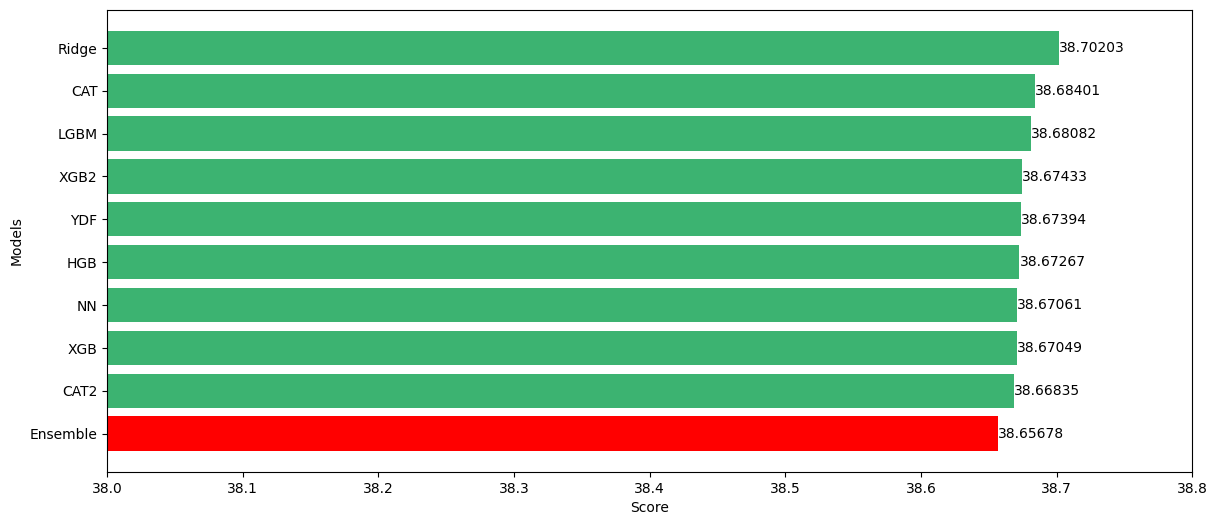

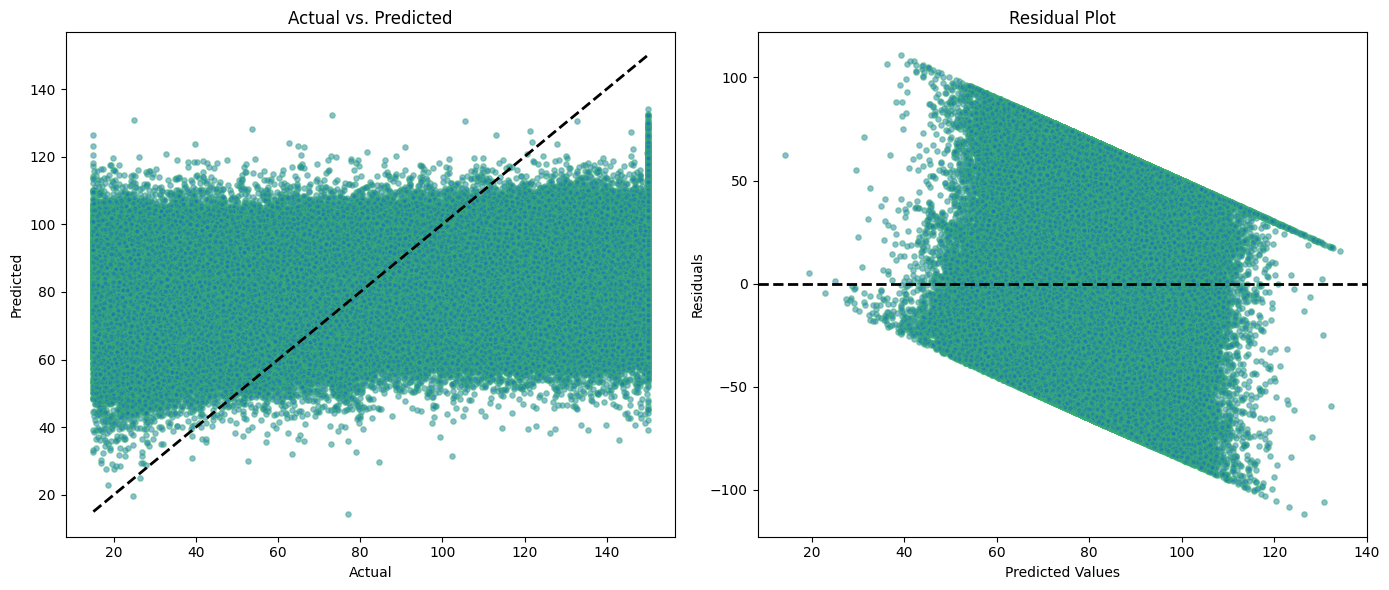

In [11]:
model = Model(X, X_enc, y, test, test_enc, models)
TEST_preds = model.train()

# <p style="border-radius: 40px; color: white; font-weight: bold; font-size: 150%; text-align: center; background-color:#3cb371; padding: 5px 5px 5px 5px;">Submission</p>

,id,Price
0,300000,82.405495
1,300001,82.779936
2,300002,90.312460
3,300003,77.371379
4,300004,79.560398


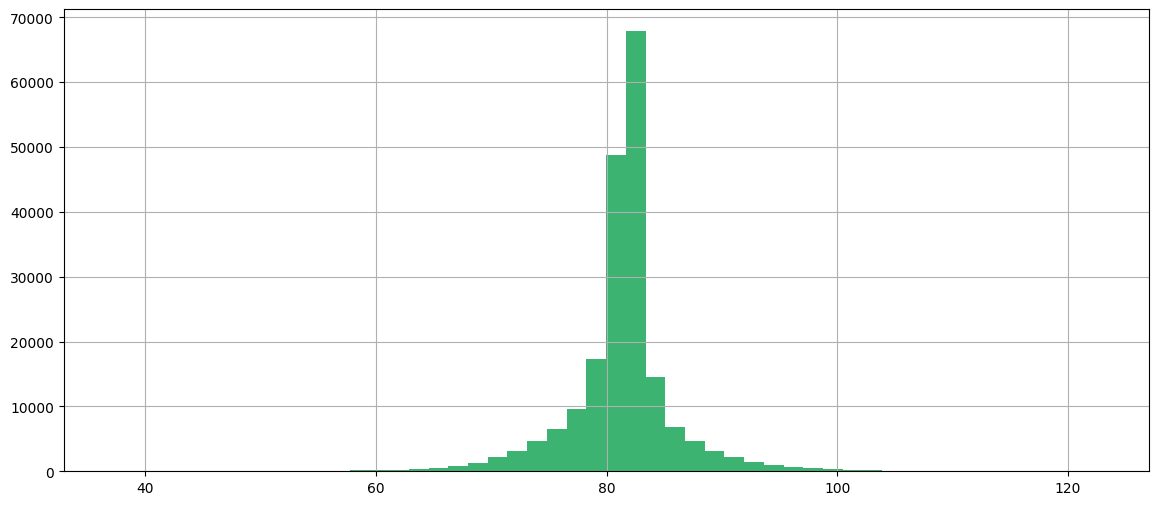

In [12]:
submission = Config.submission
submission[Config.target] = TEST_preds['Ensemble'].values
submission.to_csv("submission.csv", index=False)

display(submission.head())
plt.figure(figsize=(14, 6))
submission[Config.target].hist(color='#3cb371', bins=50)
plt.show()